<a href="https://colab.research.google.com/github/kkoma2623/VisualComputing/blob/master/AutoEncoder_(TensorFlow_2)_%EA%B8%B0%EB%B0%98_%EC%83%9D%EC%84%B1%EB%AA%A8%EB%8D%B8_kkoma2623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더 (TensorFlow 2)
텐서플로우 2에서 제공하는 고수준 API인 케라스를 이용해, 오토인코더(autoencoder)를 구현한다.
* Google Colab 환경에서 사용하는 경우에  초점을 맞춤.
* 텐서플로우 2
* 텐서플로우 2 내장 케라스 기준

참고문헌
* [TensorFlow 소개](https://www.tensorflow.org/learn)
* [TensorFlow > 학습 > TensorFlow Core > 가이드 > 케라스: 빠르게 훑어보기](https://www.tensorflow.org/guide/keras/overview)
* [Deep Learning with Python, by Francois Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)


## Tensorflow 2과 Keras를 사용하기 위한 구성
```
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.
```

In [0]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.2.0-rc3
2.3.0-tf


## MNIST 데이터셋 띄우기
* mnist 데이터셋은 LeCun이 만든 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.


### MNIST 이미지 데이터
* 트레이닝 이미지와 테스트 이미지에 들어 있는 영상은 3차원 텐서이다.
  + 트레이닝 이미지의 경우, shape = (60000, 28, 28)
  + 테스트 이미지의 경우, shape=(10000, 28, 28)
* 3차원 텐서는 다음의 의미로 구성되어 있음을 유념하자.
  + (# of images, image Height, image Width)  혹은 (# of images, # of Rows, # of Columns)  
* 각 영상은 28 x 28 크기로 구성되어 있다.
* 각 픽셀은 [0, 255] 사이의 uint8형 값이다.
  + 반드시, 텐서플로우에 입력으로 넣을 때, 픽셀값을 [0, 1] 사이의 float32형 값으로 변환하도록 하자.


### MNIST 라벨 데이터
* 각 라벨은 [0, 9] 사이의 unit8형 값이다.

In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
test_images = np.reshape(test_images, (len(test_images), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

# train_images = np.where(train_images > 0.55, 1., 0.)
# test_images = np.where(test_images > 0.55, 1., 0.)

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)
print(len(train_labels))

train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28, 1) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28, 1) <dtype: 'float32'>
(28, 28, 1)
<dtype: 'float32'>
uint8
60000


## 네트워크 모델 설계
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (28,28, 1) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28,28, 1) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계

여기서는 n_dim을 우선 2로 설정한다.
* 즉, n_dim=2

In [0]:
n_dim = 2

인코더 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* 컨볼루션 레이어를 활용하여 (28,28,1)
* 컨볼루션 레이어 층을 이용하여 (28,28,1) > (28, 28, 2) > (14, 14, 8) > (14, 14, 16) > (7, 7, 16) > (7, 7, 64) 로 변경
* Flatten으로 입력 텐서를 3136-vector로 벡터라이즈
* Fully connected layer로 3136 > n_dim 로 차원 축소

In [0]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(8, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim),
])

디코더 모델 정의
* Fully connected layey로 n_dim > 3136 로 차원 확대
* 3136-vector를 Reshape을 통해 (7, 7, 64)의 텐서로 변환
* (7, 7, 64)의 텐서를 (28, 28, 1)의 텐서로 변환

In [0]:
dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),
  tf.keras.layers.Dense(units=7*7*64, activation='relu'),
  tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.UpSampling2D((2,2)),
  tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.UpSampling2D((2,2)),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(1, (3, 3), padding='same'),
])

AutoEncoder 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [0]:
ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (28, 28, 1) -> ae -> (28, 28, 1)로 동작하지 않고,
    - batch 단위로 (?, 28, 28, 1) -> ae -> (?, 28, 28, 1)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [0]:
y_pred = ae(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화


In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 2)         20        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         152       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          9280      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6

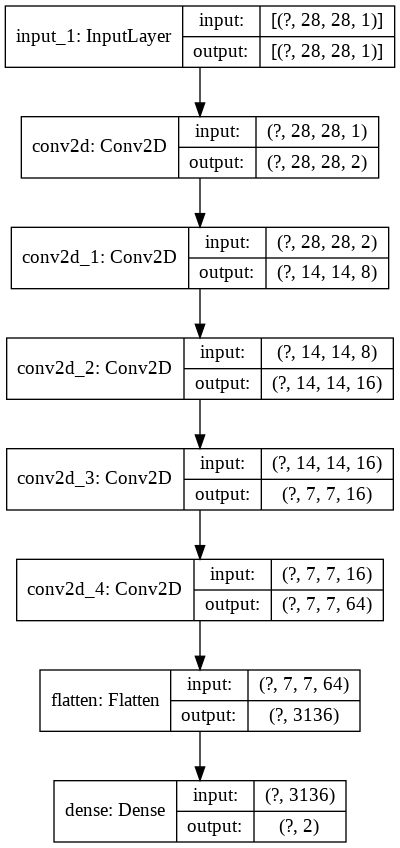

In [0]:
enc.summary()
tf.keras.utils.plot_model(enc, 'enc.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          9232      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 2)        

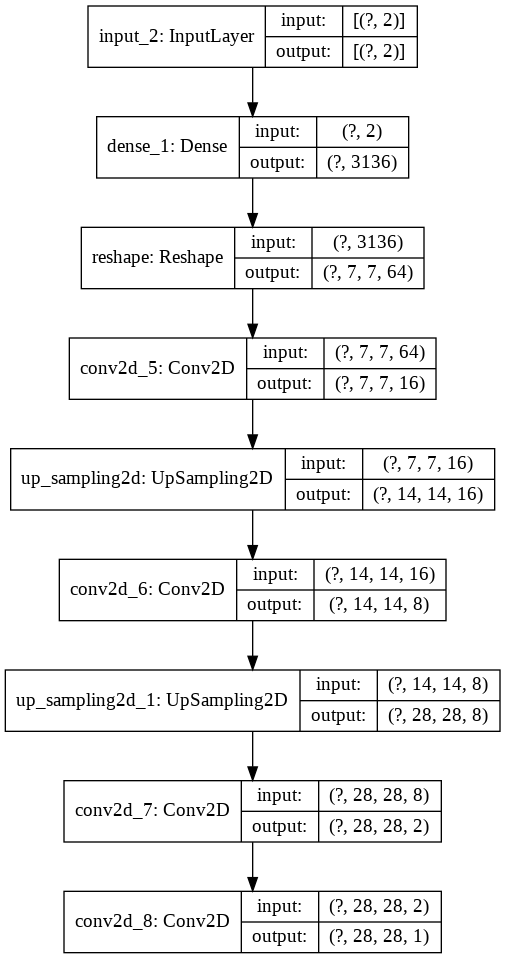

In [0]:
dec.summary()
tf.keras.utils.plot_model(dec, 'dec.png', show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 19214     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         19965     
Total params: 39,179
Trainable params: 39,179
Non-trainable params: 0
_________________________________________________________________


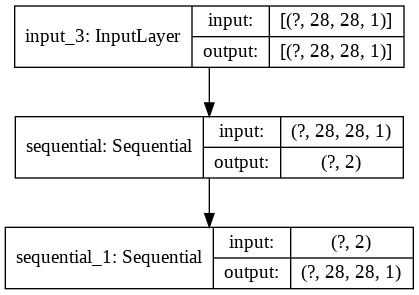

In [0]:
ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae에 대한 훈련 수행
* 인스턴스 ae를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + cf) shader program 컴파일과 유사하게 이해해도 됨
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
  + Optmizer에 대한 이론적 내용은 [이곳](https://brunch.co.kr/@chris-song/50)을 참고하세요.
* 훈련 데이터 쌍 (train_images, train_labels)으로 fit()을 이용해 훈련 

In [0]:
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0499 - mae: 0.1155
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0437 - mae: 0.1028
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0419 - mae: 0.0992
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0409 - mae: 0.0972
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0402 - mae: 0.0958
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0397 - mae: 0.0947
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0393 - mae: 0.0940
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0391 - mae: 0.0934
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0388 - mae: 0.0929
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0386 - mae: 0.0924


트레이닝 이후 ae 함수를 다시 수행

In [0]:
y_pred = ae(train_images)

In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
다음과 같은 방법으로 트레이닝이 끝난 오토인코더의 enc와 dec를 각각 수행할 수 있다.

In [0]:
z = enc(train_images)
y_pred = dec(z)

## 인코딩 결과 확인 및 디코딩 결과 확인
* 특정 이미지에 대한 인코딩 결과를 확인한다.
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [0]:
import ipywidgets as widgets

def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [0]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
# u2=widgets.FloatSlider(min=-5.0, max=5.0)
# v2=widgets.FloatSlider(min=-5.0, max=5.0)
# u3=widgets.FloatSlider(min=-5.0, max=5.0)
# v3=widgets.FloatSlider(min=-5.0, max=5.0)
# u4=widgets.FloatSlider(min=-5.0, max=5.0)
# v4=widgets.FloatSlider(min=-5.0, max=5.0)
# u5=widgets.FloatSlider(min=-5.0, max=5.0)
# v5=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u,v):
  z_test = np.array([[u,v]])  
  print(z_test)

  img_gen = dec(z_test)
  plt.imshow(np.squeeze(img_gen[0]))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

(5923, 2)
(6742, 2)
(5958, 2)
(5949, 2)


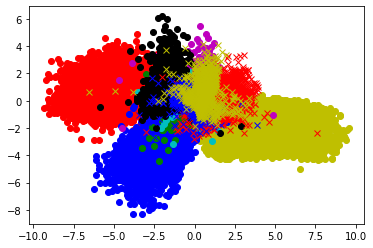

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_9.shape)

plt.plot(z_0[:,0], z_0[:,1], 'ro')
plt.plot(z_1[:,0], z_1[:,1], 'yo')
plt.plot(z_2[:,0], z_2[:,1], 'bo')
plt.plot(z_3[:,0], z_3[:,1], 'go')
plt.plot(z_4[:,0], z_4[:,1], 'mo')
plt.plot(z_5[:,0], z_5[:,1], 'co')
plt.plot(z_6[:,0], z_6[:,1], 'ko')
plt.plot(z_7[:,0], z_7[:,1], 'rx')
plt.plot(z_8[:,0], z_8[:,1], 'bx')
plt.plot(z_9[:,0], z_9[:,1], 'yx')

# 위 분포를 보면  encoder가 label 별로 discriminative한 representation을 만들어내지 못한 것을 확인할 수 있다. 어느 정도는 discriminative 하지만 대체로 그러지 못한 것을 확인할 수 있다.

## 디코더를 이용한 Generative Model 구성

In [0]:
z = np.array([[-5, 10], 
              [40, 0], 
              [5, 30]
             ])

result = dec(z)

print(z.shape)
print(result.shape)

(3, 2)
(3, 28, 28, 1)


결과 가시화

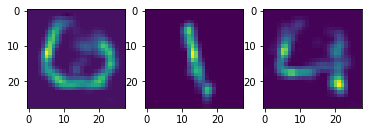

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(np.squeeze(result[0]))
plt.subplot(132)
plt.imshow(np.squeeze(result[1]))
plt.subplot(133)
plt.imshow(np.squeeze(result[2]))

In [0]:
ae.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

## 네트워크 모델 설계 2 (Z의 차원 변경)
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (28,28, 1) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28,28, 1) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계
* 위에서 z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내지 못한것을 확인하고 z의 차원을 10으로 바꿔서 실험을 해보았다.

여기서는 n_dim2을 10으로 설정한다.
* 즉, n_dim2=10

In [0]:
n_dim2 = 10

인코더 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* 컨볼루션 레이어를 활용하여 (28,28,1)
* 컨볼루션 레이어 층을 이용하여 (28,28,1) > (28, 28, 2) > (14, 14, 8) > (14, 14, 16) > (7, 7, 16) > (7, 7, 64) 로 변경
* Flatten으로 입력 텐서를 3136-vector로 벡터라이즈
* Fully connected layer로 3136 > n_dim2 로 차원 축소

In [0]:
enc2 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(8, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim2),
])

디코더 모델 정의
* Fully connected layey로 n_dim2 > 3136 로 차원 확대
* 3136-vector를 Reshape을 통해 (7, 7, 64)의 텐서로 변환
* (7, 7, 64)의 텐서를 (28, 28, 1)의 텐서로 변환

In [0]:
dec2 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim2,)),
  tf.keras.layers.Dense(units=7*7*64, activation='relu'),
  tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.UpSampling2D((2,2)),
  tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.UpSampling2D((2,2)),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(1, (3, 3), padding='same'),
])

AutoEncoder 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [0]:
ae2 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc2,
  dec2,                               
])

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (28, 28, 1) -> ae2 -> (28, 28, 1)로 동작하지 않고,
    - batch 단위로 (?, 28, 28, 1) -> ae2 -> (?, 28, 28, 1)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [0]:
y_pred2 = ae2(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred2.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화


In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred2[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 2)         20        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 8)         152       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          9280      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

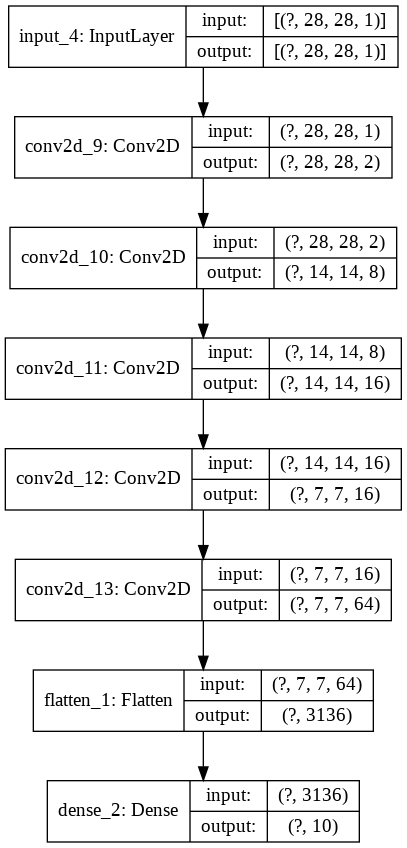

In [0]:
enc2.summary()
tf.keras.utils.plot_model(enc2, 'enc.png', show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 16)          9232      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 2)        

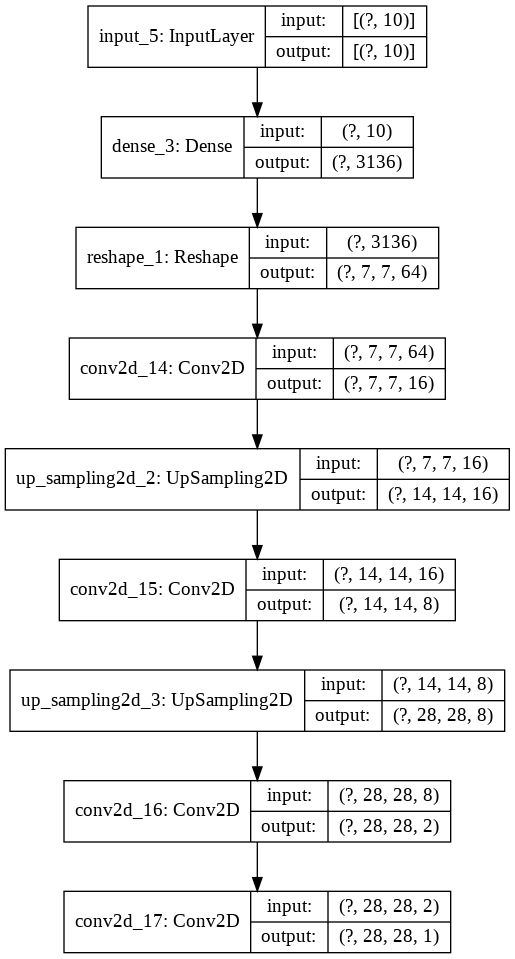

In [0]:
dec2.summary()
tf.keras.utils.plot_model(dec2, 'dec.png', show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 10)                44310     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         45053     
Total params: 89,363
Trainable params: 89,363
Non-trainable params: 0
_________________________________________________________________


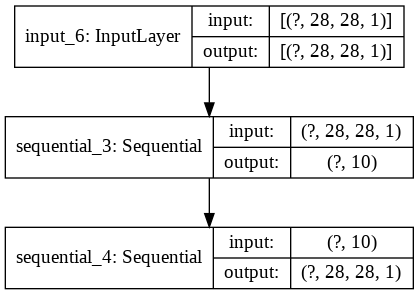

In [0]:
ae2.summary()
tf.keras.utils.plot_model(ae2, 'ae.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae2에 대한 훈련 수행
* 인스턴스 ae2를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + cf) shader program 컴파일과 유사하게 이해해도 됨
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
  + Optmizer에 대한 이론적 내용은 [이곳](https://brunch.co.kr/@chris-song/50)을 참고하세요.
* 훈련 데이터 쌍 (train_images, train_labels)으로 fit()을 이용해 훈련 

In [0]:
ae2.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae2.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0245 - mae: 0.0684
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0156 - mae: 0.0487
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0143 - mae: 0.0458
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0136 - mae: 0.0440
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0131 - mae: 0.0425
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0127 - mae: 0.0415
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0124 - mae: 0.0408
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0122 - mae: 0.0402
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0120 - mae: 0.0397
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0118 - mae: 0.0393


트레이닝 이후 ae2 함수를 다시 수행

In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred2[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
다음과 같은 방법으로 트레이닝이 끝난 오토인코더의 enc와 dec를 각각 수행할 수 있다.

In [0]:
z2 = enc2(train_images)
y_pred2 = dec2(z2)

## 인코딩 결과 확인 및 디코딩 결과 확인
* 특정 이미지에 대한 인코딩 결과를 확인한다.
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [0]:
import ipywidgets as widgets

def z_show2(idx):
  print(z2[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show2, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [0]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
u2=widgets.FloatSlider(min=-5.0, max=5.0)
v2=widgets.FloatSlider(min=-5.0, max=5.0)
u3=widgets.FloatSlider(min=-5.0, max=5.0)
v3=widgets.FloatSlider(min=-5.0, max=5.0)
u4=widgets.FloatSlider(min=-5.0, max=5.0)
v4=widgets.FloatSlider(min=-5.0, max=5.0)
u5=widgets.FloatSlider(min=-5.0, max=5.0)
v5=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v, u2,v2, u3,v3, u4,v4, u5,v5])

def z_test2(u,v, u2,v2, u3,v3, u4,v4, u5,v5):
  z_test2 = np.array([[u,v, u2,v2, u3,v3, u4,v4, u5,v5]])  
  print(z_test2)

  img_gen2 = dec2(z_test2)
  plt.imshow(np.squeeze(img_gen2[0]))
  plt.show()  

out2 = widgets.interactive_output(z_test2, {'u': u, 'v': v, 'u2': u2, 'v2': v2, 'u3': u3, 'v3': v3, 'u4': u4, 'v4': v4, 'u5': u5, 'v5': v5})

display(ui, out2)

Output()

## 인코딩 결과 가시화
* 오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 
TSNE를 사용하여 표현하였다.
* 2차원을 넘어서 표현했기 때문에 TSNE를 사용하였다.

(60000, 10)


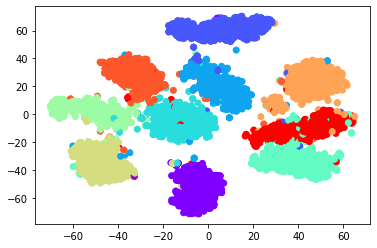

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100)
print(z2.shape)
transformed = model.fit_transform(z2[:6000, :])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=train_labels[:6000], cmap=plt.get_cmap('rainbow', 10))

plt.show()

# TSNE로 나타낸 분포를 살펴보았다.
* 이전 z의 차원을 2로 해보았을 때 보다 다소 encoder가 label 별로 discriminative한 representation을 만들어내는 분포를 확인할 수 있다.

## 디코더를 이용한 Generative Model 구성

In [0]:
z2 = np.array([[0.0,-0.2,0.2,0.7,1.1,0.2,2.3,-0.2,0.7,0.2], 
              [4, 0, -1, 1, -4, -2, 3, 0, 2, 1], 
              [5, 0, 1, 1, -3, -5, -2, 3, -2, 0]
             ])

result2 = dec2(z2)

print(z2.shape)
print(result2.shape)

(3, 10)
(3, 28, 28, 1)


결과 가시화

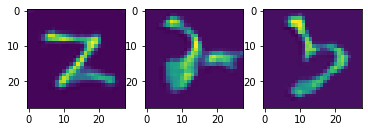

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(np.squeeze(result2[0]))
plt.subplot(132)
plt.imshow(np.squeeze(result2[1]))
plt.subplot(133)
plt.imshow(np.squeeze(result2[2]))

#첫 번째 이미지는 1과 유사하게 의미있게 만들어 진 것 같다.
* 첫 번째 출력한 이미지는 대체로 train_image의 모양이 간단하고 분포가 확실한 것 같다. 주변의 픽셀값과 구별이 뚜렷한 특징을 가지고 있다.
* 2번째 이미지는 2 또는 6을 생성하려고 한 것 같은데 이 숫자들은 모두 뭉개졌을 경우 비슷한 모양을 가지는 특징을 가지고 있다.
* 3번째 이미지의 경우 3을 출력하려고 한 것 같다.

In [0]:
ae2.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

## 네트워크 모델 설계 3 (1에서 28*28의 크기를 유지, 단 filters의 크기를 바꿔주었다.)
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (28,28, 1) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28,28, 1) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계
* 1 에서 z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내지 못한것을 확인하고 z의 차원을 2로 고정하고 28*28의 크기도 고정하여 실험을 해보았다.
* 아래의 설명은 위와 같으므로 생략하고 코드와 분석만 작성하겠다.

In [0]:
n_dim3 = 2

In [0]:
enc3 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(n_dim3),
])


In [0]:
dec3 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim3,)),
  tf.keras.layers.Dense(units=28*28*4, activation='relu'),
  tf.keras.layers.Reshape(target_shape=(28, 28, 4)),
  tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(1, (3, 3), padding='same'),
])

In [0]:
ae3 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc3,
  dec3,                               
])

In [0]:
y_pred3 = ae3(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred3.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred3[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 2)         20        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 4)         76        
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6274      
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


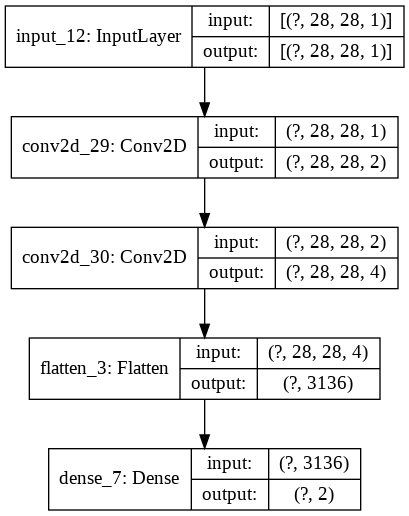

In [0]:
enc3.summary()
tf.keras.utils.plot_model(enc3, 'enc.png', show_shapes=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 4)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 4)         148       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 2)         74        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 1)         19        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


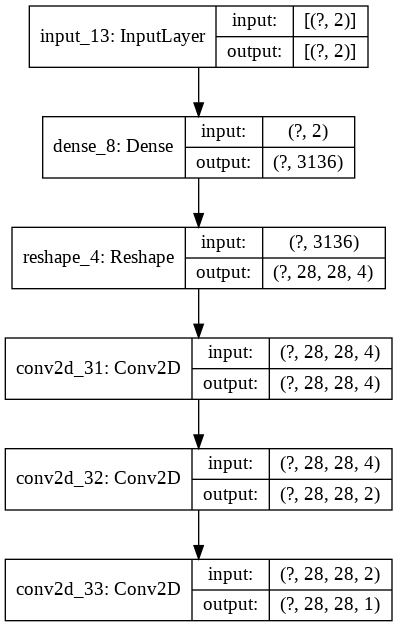

In [0]:
dec3.summary()
tf.keras.utils.plot_model(dec3, 'dec.png', show_shapes=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 2)                 6370      
_________________________________________________________________
sequential_12 (Sequential)   (None, 28, 28, 1)         9649      
Total params: 16,019
Trainable params: 16,019
Non-trainable params: 0
_________________________________________________________________


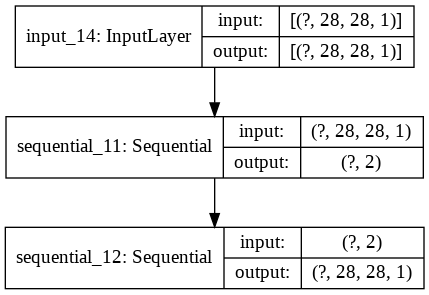

In [0]:
ae3.summary()
tf.keras.utils.plot_model(ae3, 'ae.png', show_shapes=True)

In [0]:
ae3.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae3.fit(train_images, train_images, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0555 - mae: 0.1266
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0486 - mae: 0.1128
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0471 - mae: 0.1097
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0464 - mae: 0.1083
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0460 - mae: 0.1075
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0458 - mae: 0.1070
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0456 - mae: 0.1066
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0455 - mae: 0.1064
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0454 - mae: 0.1062
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0453 - mae: 0.1060


In [0]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(np.squeeze(train_images[idx]))
  plt.subplot(122)
  plt.imshow(np.squeeze(y_pred3[idx]))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [0]:
z3 = enc3(train_images)
y_pred3 = dec3(z3)

In [0]:
import ipywidgets as widgets

def z_show3(idx):
  print(z3[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show3, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [0]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
# u2=widgets.FloatSlider(min=-5.0, max=5.0)
# v2=widgets.FloatSlider(min=-5.0, max=5.0)
# u3=widgets.FloatSlider(min=-5.0, max=5.0)
# v3=widgets.FloatSlider(min=-5.0, max=5.0)
# u4=widgets.FloatSlider(min=-5.0, max=5.0)
# v4=widgets.FloatSlider(min=-5.0, max=5.0)
# u5=widgets.FloatSlider(min=-5.0, max=5.0)
# v5=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test3(u,v):
  z_test3 = np.array([[u,v]])  
  print(z_test3)

  img_gen3 = dec3(z_test3)
  plt.imshow(np.squeeze(img_gen3[0]))
  plt.show()  

out3 = widgets.interactive_output(z_test3, {'u': u, 'v': v})

display(ui, out3)

Output()

(5923, 2)
(6742, 2)
(5958, 2)
(5949, 2)


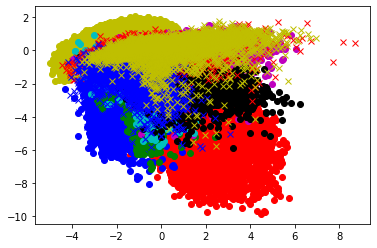

In [0]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
z3_0 = z3[train_labels==0]    # z 배열을 조건을 이용해 slice
z3_1 = z3[train_labels==1]
z3_2 = z3[train_labels==2]
z3_3 = z3[train_labels==3]
z3_4 = z3[train_labels==4]
z3_5 = z3[train_labels==5]
z3_6 = z3[train_labels==6]
z3_7 = z3[train_labels==7]
z3_8 = z3[train_labels==8]
z3_9 = z3[train_labels==9]

print(z3_0.shape)
print(z3_1.shape)
print(z3_2.shape)
print(z3_9.shape)

plt.plot(z3_0[:,0], z3_0[:,1], 'ro')
plt.plot(z3_1[:,0], z3_1[:,1], 'yo')
plt.plot(z3_2[:,0], z3_2[:,1], 'bo')
plt.plot(z3_3[:,0], z3_3[:,1], 'go')
plt.plot(z3_4[:,0], z3_4[:,1], 'mo')
plt.plot(z3_5[:,0], z3_5[:,1], 'co')
plt.plot(z3_6[:,0], z3_6[:,1], 'ko')
plt.plot(z3_7[:,0], z3_7[:,1], 'rx')
plt.plot(z3_8[:,0], z3_8[:,1], 'bx')
plt.plot(z3_9[:,0], z3_9[:,1], 'yx')

# 분포에 대한 분석
* 1과 마찬가지로 encoder가 label 별로 discriminative한 representation을 만들어내지 못한 것을 확인할 수 있다.
* 1보다 discriminative한 representation을 못만들어 내는 것 같다.
* 아마도 그래픽카드 메모리 용량 때문에 28*28을 유지를 한 상태에서 filters의 수를 많이 늘리지 못해서 층을 2개밖에 쌓지 못해서 위와 같은 결과가 나온 것 같다.

In [0]:
z3 = np.array([[0.0,-0.2], 
              [4.1, -2], 
              [-3, 1.6]
             ])

result3 = dec3(z3)

print(z3.shape)
print(result3.shape)

(3, 2)
(3, 28, 28, 1)


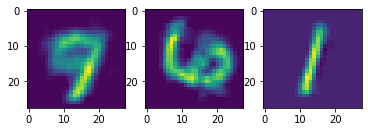

In [0]:
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(np.squeeze(result3[0]))
plt.subplot(132)
plt.imshow(np.squeeze(result3[1]))
plt.subplot(133)
plt.imshow(np.squeeze(result3[2]))

# 임의의 값을 디코더에 넣었을 경우
* 2에서 실험한 것 보다 숫자에 가까운 이미지를 생성해낸다.
* 아마 28*28로 유지를 해서 배열의 크기가 줄지 않으면서 데이터 손실이 적게 되어서 그런 것으로 유추하고 있다.

In [0]:
ae3.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}